# Visualize BALD Scores for the Test Set During Training
> Resistance is futile.

In [ ]:
# hide
import blackhc.project.script

Appended /home/blackhc/PycharmProjects/bald-ical/src to paths
Switched to directory /home/blackhc/PycharmProjects/bald-ical
%load_ext autoreload
%autoreload 2


Import modules and functions were are going to use.

In [ ]:
import torch

In [ ]:
results = torch.load("extracted_scores_results.tpickle")

In [ ]:
import collections
import functools
import math
import os
import re
from collections import namedtuple
from dataclasses import dataclass
from typing import NamedTuple

import laaos
import pandas as pd
import seaborn as sns

In [ ]:
# https://codereview.stackexchange.com/questions/85311/transform-snake-case-to-camelcase
def camel_case_name(snake_case_name):
    return re.sub("_([a-z])", lambda match: match.group(1).upper(), snake_case_name)


__namedtuples = {}


def to_namedtuple(obj, name):
    type_name = "_" + camel_case_name(name)
    if isinstance(obj, dict):
        keys = tuple(obj.keys())
        if keys in __namedtuples:
            nt = __namedtuples[keys]
        else:
            nt = namedtuple(type_name, keys)
            __namedtuples[keys] = nt
        return nt(*(to_namedtuple(v, k) for k, v in obj.items()))
    if isinstance(obj, list):
        item_type_name = type_name + "Item"
        return [to_namedtuple(item, item_type_name) for item in obj]
    if isinstance(obj, set):
        item_type_name = type_name + "Item"
        return {to_namedtuple(item, item_type_name) for item in obj}
    if isinstance(obj, tuple):
        item_type_name = type_name + "Item"
        return tuple(to_namedtuple(item, item_type_name) for item in obj)

    return obj


def get_any(d: dict):
    return next(iter(d.values()))


def handle_map_funcs(func_kv, func_k, func_v, default=None):
    if func_kv:
        assert func_k is None and func_v is None

        def inner(kv):
            return func_kv(*kv)

    elif func_k:
        assert func_v is None

        def inner(kv):
            return func_k(kv[0]), kv[1]

    elif func_v:

        def inner(kv):
            return kv[0], func_v(kv[1])

    else:
        return default
    return inner


def handle_unary_funcs(pred_kv, pred_k, pred_v, default=None):
    if pred_kv:
        assert pred_k is None and pred_v is None

        def inner(kv):
            return pred_kv(*kv)

    elif pred_k:
        assert pred_v is None

        def inner(kv):
            return pred_k(kv[0])

    elif pred_v:

        def inner(kv):
            return pred_v(kv[1])

    else:
        return default
    return inner


def map_dict(d: dict, *, kv=None, k=None, v=None):
    inner = handle_map_funcs(kv, k, v)
    return dict(map(inner, d.items()))


def filter_dict(d: dict, *, kv=None, k=None, v=None):
    inner_pred = handle_unary_funcs(kv, k, v)
    return dict(filter(inner_pred, d.items()))


def sort_dict(d: dict, *, reverse=False, kv=None, k=None, v=None):
    inner_key = handle_unary_funcs(kv, k, v, default=lambda ikv: ikv[0])
    return dict(sorted(d.items(), key=inner_key, reverse=reverse))


def groupby_dict(d: dict, *, key_kv=None, key_k=None, key_v=None, agg=None):
    inner_key = handle_unary_funcs(key_kv, key_k, key_v)

    grouped_by = {}
    for kv in d.items():
        new_key = inner_key(kv)
        if new_key not in grouped_by:
            grouped_by[new_key] = {}
        key, value = kv
        grouped_by[new_key][key] = value

    if agg is not None:
        return map_dict(grouped_by, v=agg)

    return grouped_by

In [ ]:
results = to_namedtuple(results, "Results")

In [ ]:
total_acquistion_size = len(results.active_learning_steps) - 1
total_acquistion_size

230

In [ ]:
accuracies = [step.evaluation_metrics.accuracy for step in results.active_learning_steps]
accuracies[0], accuracies[100]

(0.7328, 0.9281)

In [ ]:
bald_test_scores = [
    step.bald_test_scores for _, step in zip(range(total_acquistion_size), results.active_learning_steps)
]
entropy_test_scores = [
    step.entropy_test_scores for _, step in zip(range(total_acquistion_size), results.active_learning_steps)
]

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns

In [ ]:
test_scores = entropy_test_scores

In [ ]:
sorted_indices = [np.argsort(-scores) for scores in test_scores]

In [ ]:
def get_rank_correlation_df(test_scores, *, start_step: int, top: bool):
    test_scores = test_scores[start_step:]

    base_scores = test_scores[0]
    sorted_indices = [np.argsort(-scores) for scores in test_scores]
    rows = []

    for sample_size in (10000, 4000, 2000, 1000, 500, 200, 100, 50, 10):
        sample_slice = slice(None, sample_size) if top else slice(-sample_size, None)

        #merged_indices = list(set.union(*(set(indices[sample_slice].tolist()) for indices in sorted_indices)))
        merged_indices = sorted_indices[0][sample_slice]
        print(sample_size, len(merged_indices))
        rank_correlations = [
            scipy.stats.spearmanr(base_scores[merged_indices], other_scores[merged_indices]).correlation
            for other_scores in test_scores
        ]
        # rows.append(dict(top_k_samples=f"{sample_size} from each acquisition ({len(merged_indices)})", acquisition=list(range(len(rank_correlations))), rank_correlations=rank_correlations))
        rows.append(
            dict(
                nominal_sample_size=sample_size,
                merged_sample_size=len(merged_indices),
                acquisition=list(range(len(rank_correlations))),
                rank_correlations=rank_correlations,
            )
        )

    df = pd.DataFrame.from_dict(rows)
    df["boundary"] = "top" if top else "bottom"
    df["start_step"] = start_step
    return df

In [ ]:
df = get_rank_correlation_df(bald_test_scores, top=True, start_step=0)

10000 10000
4000 4000
2000 2000
1000 1000
500 500
200 200
100 100
50 50
10 10


In [ ]:
df

,nominal_sample_size,merged_sample_size,acquisition,rank_correlations,boundary,start_step
0,10000,10000,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[1.0, 0.8355383389833834, 0.7308123183001233, ...",top,0
1,4000,4000,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.9999999999999998, 0.48177588461099274, 0.27...",top,0
2,2000,2000,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[1.0, 0.36274860968715245, 0.07018330454582614...",top,0
3,1000,1000,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[1.0, 0.32506400506400507, -0.0185166785166785...",top,0
4,500,500,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[1.0, 0.2932748370993484, -0.05663091452365809...",top,0
5,200,200,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[1.0, 0.09645691142278558, 0.02109802745068627...",top,0
6,100,100,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.9999999999999999, 0.056609660966096605, -0....",top,0
7,50,50,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.9999999999999999, 0.1495798319327731, -0.01...",top,0
8,10,10,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.9999999999999999, 0.4545454545454545, 0.296...",top,0


In [ ]:
df["top_k_samples_caption"] = df.apply(
    lambda row: f"{row.nominal_sample_size} from each acquisition ({row.merged_sample_size})", axis=1
)

In [ ]:
df = df.explode(["acquisition", "rank_correlations"])
df

In [ ]:
sns.catplot(
    data=df,
    x="acquisition",
    y="rank_correlations",
    row="top_k_samples_caption",
    kind="bar",
    sharex=True,
    aspect=7,
    height=3,
)

In [ ]:
df = pd.concat(
    [
        get_rank_correlation_df(bald_test_scores, start_step=0, top=True),
        get_rank_correlation_df(bald_test_scores, start_step=0, top=False),
        get_rank_correlation_df(bald_test_scores, start_step=100, top=True),
        get_rank_correlation_df(bald_test_scores, start_step=100, top=False),
    ]
)

10000 10000
4000 4000
2000 2000
1000 1000
500 500
200 200
100 100
50 50
10 10
10000 10000
4000 4000
2000 2000
1000 1000
500 500
200 200
100 100
50 50
10 10
10000 10000
4000 4000
2000 2000
1000 1000
500 500
200 200
100 100
50 50
10 10
10000 10000
4000 4000
2000 2000
1000 1000
500 500
200 200
100 100
50 50
10 10


In [ ]:
real_rank_correlations = get_rank_correlation_df(bald_test_scores, start_step=100, top=True)

10000 10000
4000 4000
2000 2000
1000 1000
500 500
200 200
100 100
50 50
10 10


In [ ]:
def get_simulated_scores(test_scores, *, exp_lambda:float, type="power"):
    score = test_scores[0]
    simulated_scores = [score]
    for _ in test_scores[1:]:
        if type=="sim":
            score /= 1 + np.random.exponential(exp_lambda, size=len(score))
        elif type=="power":
            score /= np.random.exponential(exp_lambda, size=len(score))
        elif type=="softmax":
            score += scipy.stats.gumbel_r.rvs(loc=0, scale=exp_lambda, size=len(score), random_state=None)
        else:
            assert False
        simulated_scores += [score]
    return simulated_scores

In [ ]:
simulated_rank_correlations = [
    get_rank_correlation_df(get_simulated_scores(bald_test_scores[100:], exp_lambda=1, type="sim"), start_step=0, top=True)
    for _ in range(3)
]

10000 10000
4000 4000
2000 2000
1000 1000
500 500
200 200
100 100
50 50
10 10
10000 10000
4000 4000
2000 2000
1000 1000
500 500
200 200
100 100
50 50
10 10
10000 10000
4000 4000
2000 2000
1000 1000
500 500
200 200
100 100
50 50
10 10


Text(0.5, 0.98, 'Sim with Lambda=1 @ 100')

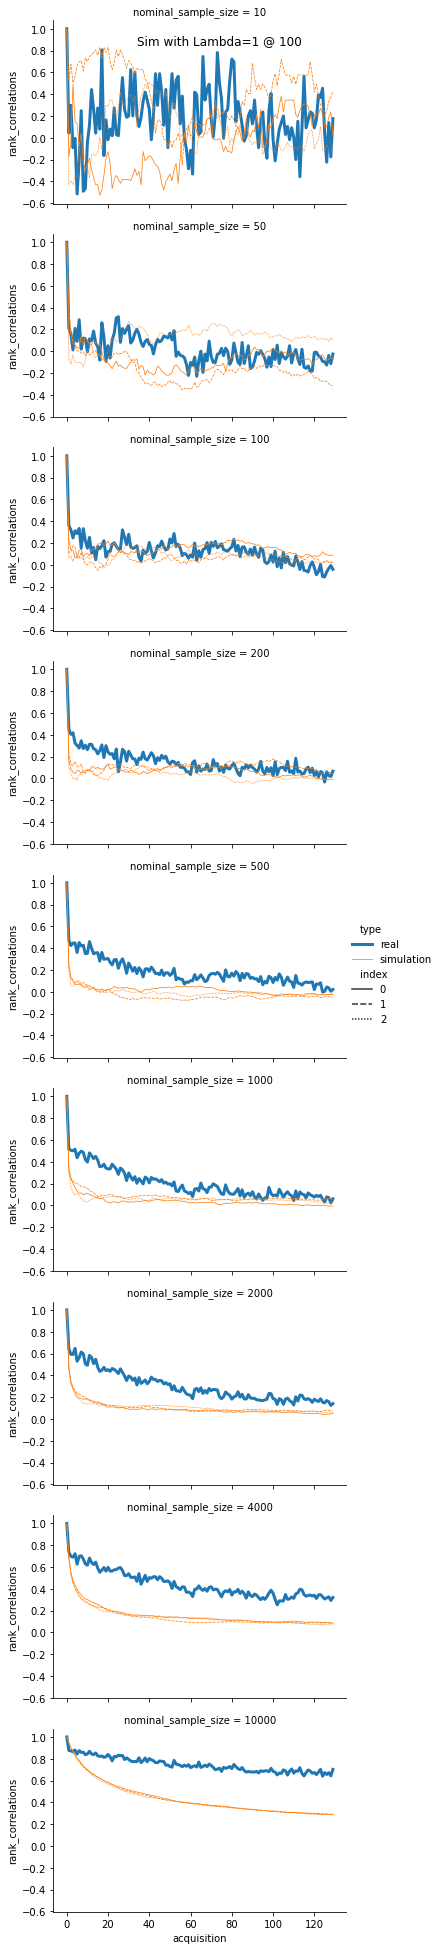

In [ ]:
df1 = real_rank_correlations.explode(["acquisition", "rank_correlations"])
df1["type"] = "real"
df1["index"] = 0
dfs = [df1]
for i, src in enumerate(simulated_rank_correlations):
    df2 = src.explode(["acquisition", "rank_correlations"])
    df2["type"] = "simulation"
    df2["index"] = i
    dfs += [df2]
df12 = pd.concat(dfs)
g = sns.relplot(
    data=df12,
    x="acquisition",
    y="rank_correlations",
    row="nominal_sample_size",
    hue="type",
    size="type",
    style="index",
    kind="line",
    # sharex=True,
    aspect=1.62,
    height=3,
    #ci="sd",
)
g.fig.suptitle("Sim with Lambda=1 @ 100")

In [ ]:
df.explode(["acquisition", "rank_correlations"]).to_csv("BALD_rank_correlations.csv.xz", index=False)

In [ ]:
!ls -lh "BALD_rank_correlations.csv.xz"

In [ ]:
df = get_rank_correlation_df(bald_test_scores, top=False, start_step=0)

In [ ]:
df["bottom_k_samples_caption"] = df.apply(
    lambda row: f"{row.nominal_sample_size} from each acquisition ({row.merged_sample_size})", axis=1
)

In [ ]:
df = df.explode(["acquisition", "rank_correlations"])
df

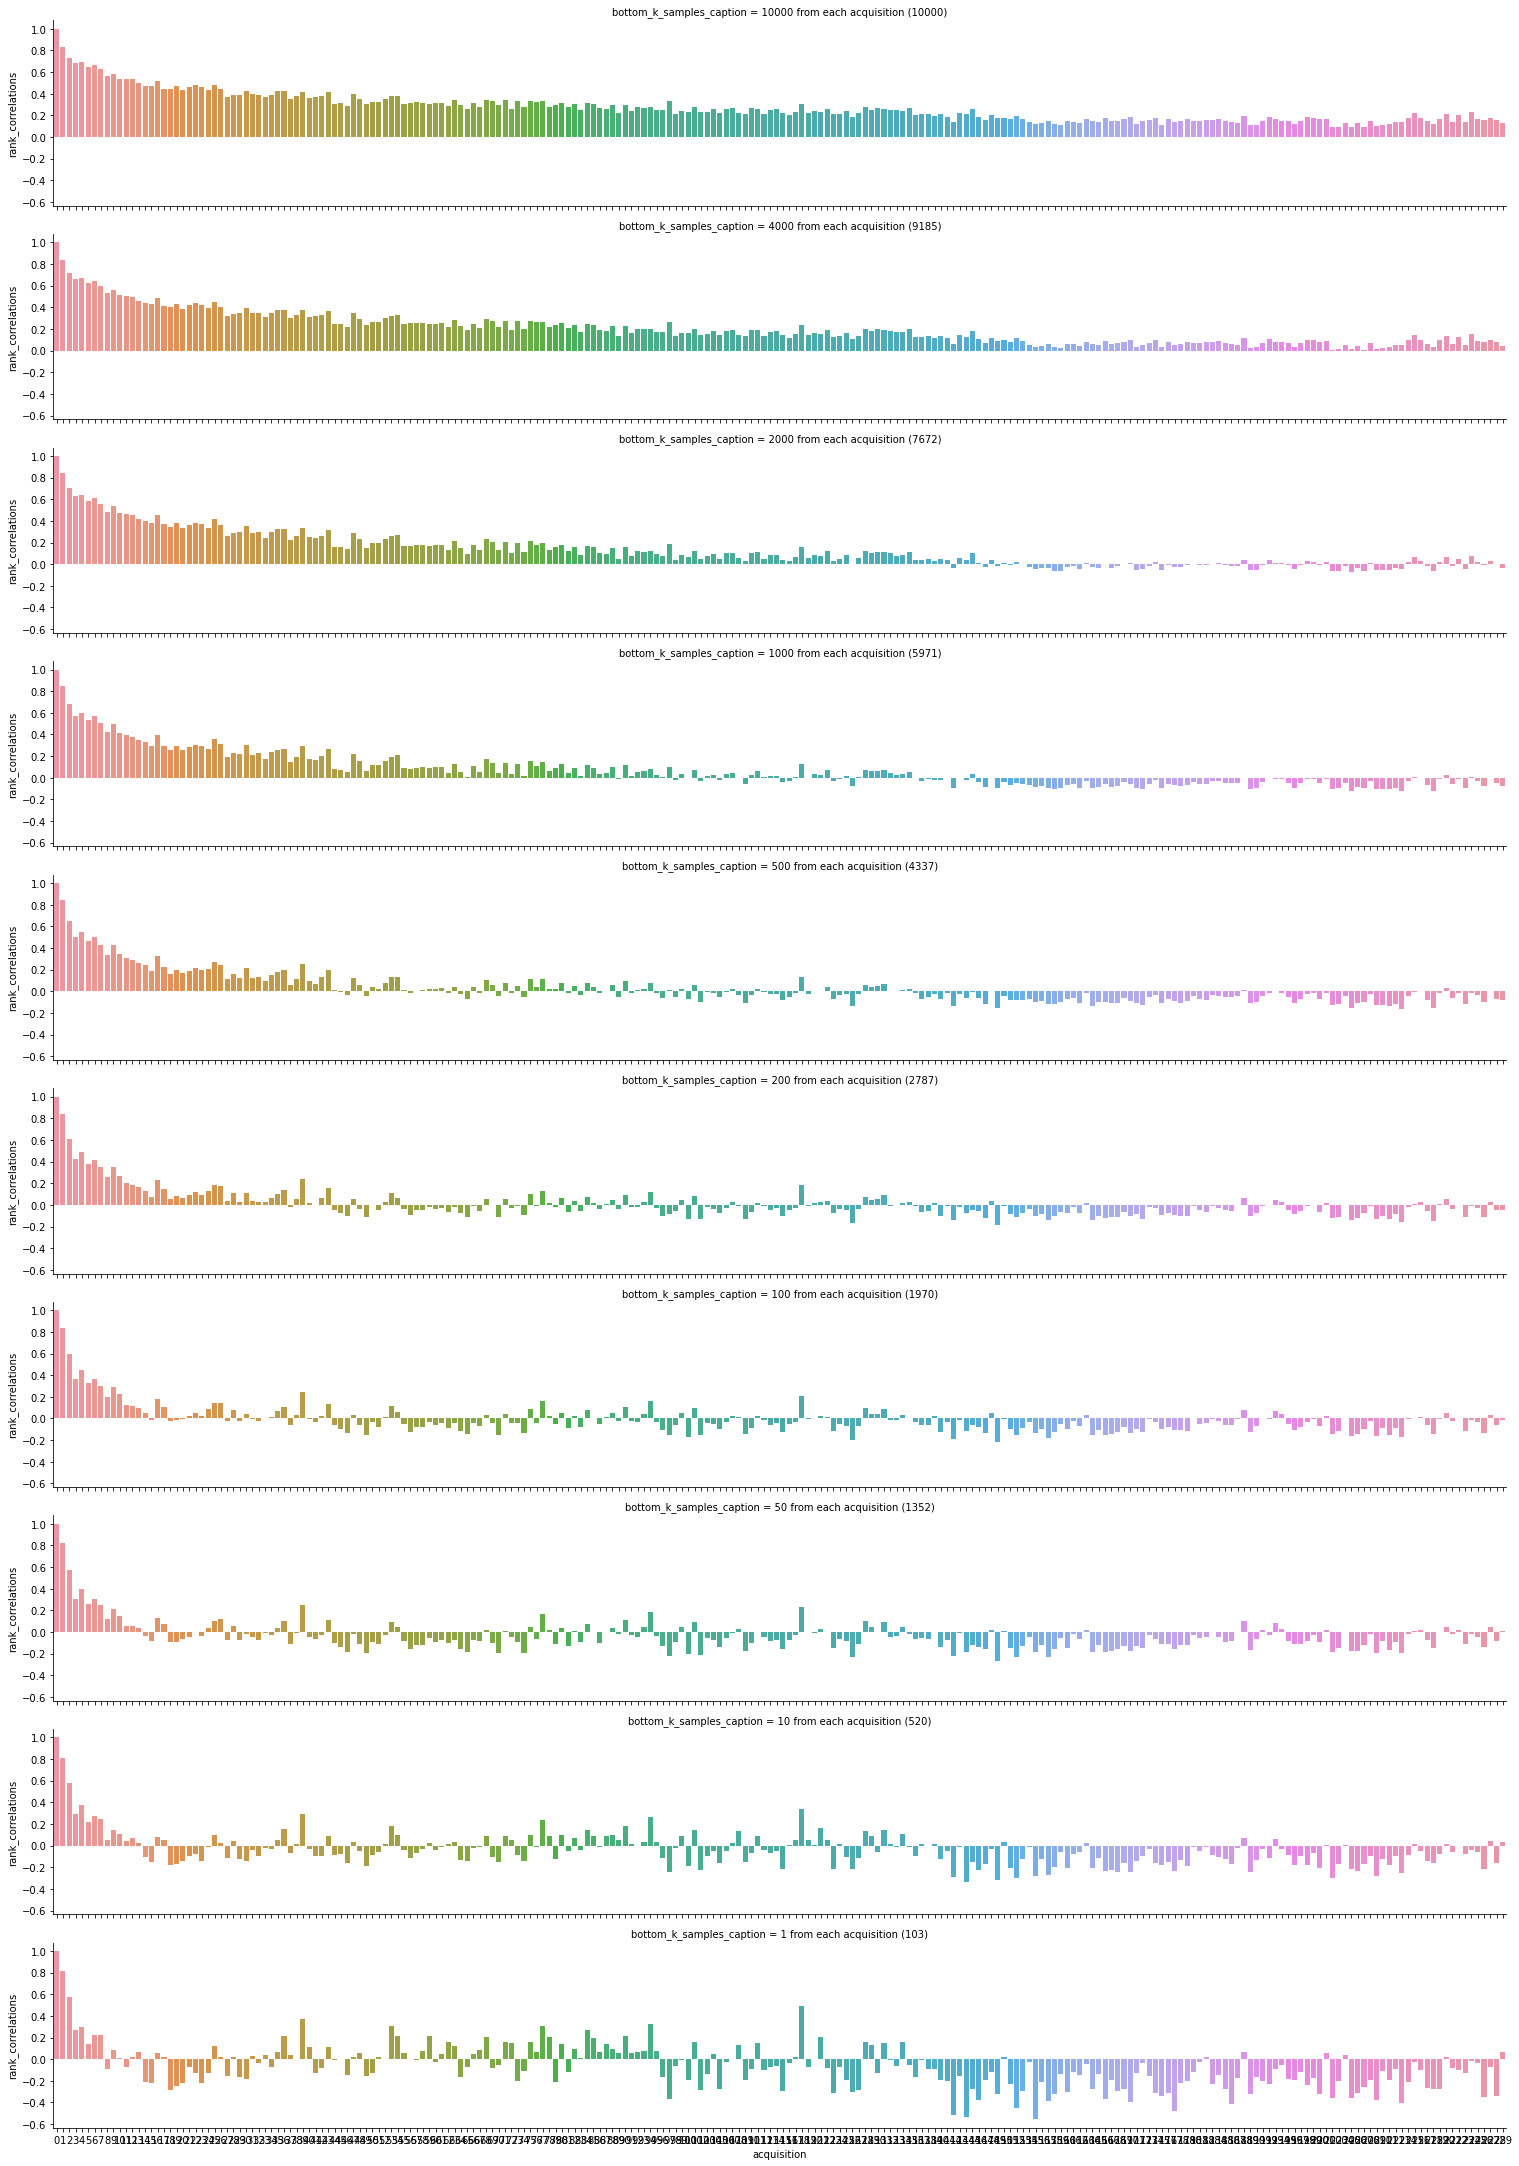

In [ ]:
sns.catplot(
    data=df,
    x="acquisition",
    y="rank_correlations",
    row="bottom_k_samples_caption",
    kind="bar",
    sharex=True,
    aspect=7,
    height=3,
)

# Get Stochastic Score Distributions (for Investigation)

In [ ]:
def get_score_distributions(scores: torch.Tensor, coldness: float):
    scores = torch.sort(scores, descending=True)[0]
    idx = list(range(len(scores)))

    softmax_distribution = torch.nn.functional.softmax(coldness * scores)
    power_distribution = scores ** coldness
    power_distribution /= power_distribution.sum()
    rank_distribution = torch.argsort(scores, descending=True)
    rank_distribution = 1 / (1.0 + torch.argsort(rank_distribution)) ** coldness
    rank_distribution /= rank_distribution.sum()
    # print(rank_distribution[0])

    frame = dict(
        idx=idx,
        coldness=coldness,
        temperature=1 / coldness,  # scores = scores.numpy(),
        power=power_distribution,
        softmax=softmax_distribution,
        softrank=rank_distribution,
    )
    return pd.DataFrame(frame)

In [ ]:
np.log(1/2)

-0.6931471805599453

<ipython-input-87-96e949304158>:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  softmax_distribution = torch.nn.functional.softmax(coldness * scores)


(0.0, 0.0002)

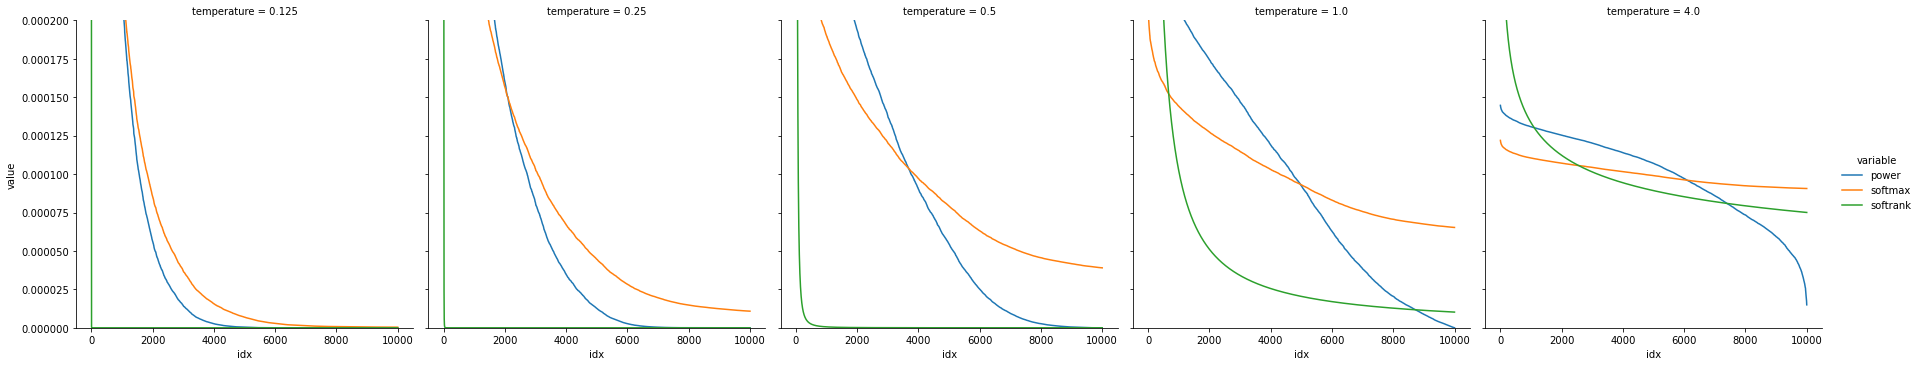

In [ ]:
step = 0
show_log = False
scores_distribution_df = pd.concat(
    [get_score_distributions(bald_test_scores[step], coldness) for coldness in [1/4, 1, 2, 4, 8]], ignore_index=True
)
melted_scores_distribution_df = scores_distribution_df.melt(id_vars=["idx", "temperature", "coldness"])

sns.relplot(
    data=melted_scores_distribution_df, #[melted_scores_distribution_df.variable != "softrank"],
    x="idx",
    y="value",
    hue="variable",
    col="temperature",
    kind="line",
    facet_kws=dict(sharey=True),
    palette=sns.color_palette(n_colors=3),
)
# sns.relplot(data=melted_scores_distribution_df, x="idx", y="value", hue="variable", col="temperature", kind="line", facet_kws=dict(sharey=True), palette=sns.color_palette(n_colors=3))

mean = scores_distribution_df["softmax"].mean()

#plt.yscale("log")

plt.ylim(0, 0.0002)

#plt.gca().set_yscale("functionlog", functions=[lambda x: np.log(x), lambda x:  np.exp(x)])
#plt.gca().set_ylim(1e-18, 10)
# if show_log:

#     for ax in g.axes[0]:
#         ax.set_yscale("log")

In [ ]:
melted_scores_distribution_df.to_csv("BALD_score_distribution_comparison.csv.xz", index=False)

<ipython-input-137-6122d400e940>:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  softmax_distribution = torch.nn.functional.softmax(coldness*scores)


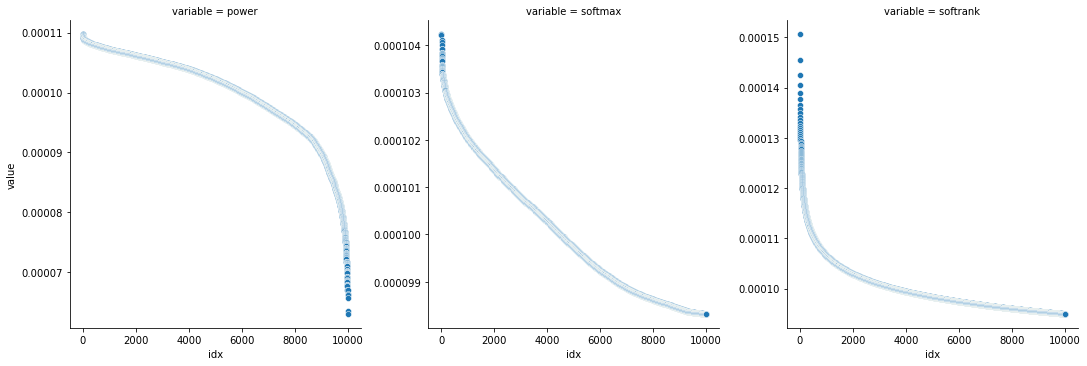

In [ ]:
scores_distribution_df = get_score_distributions(bald_test_scores[step], 1 / 20)
melted_scores_distribution_df = scores_distribution_df.melt(id_vars="idx")

sns.relplot(data=melted_scores_distribution_df, x="idx", y="value", col="variable", facet_kws=dict(sharey=False))

if show_log:
    for ax in g.axes[0]:
        ax.set_yscale("log")

<ipython-input-137-6122d400e940>:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  softmax_distribution = torch.nn.functional.softmax(coldness*scores)


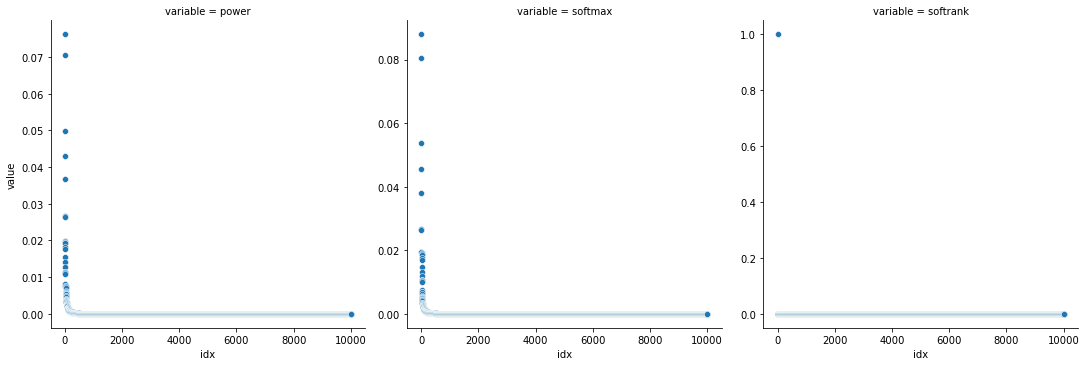

In [ ]:
scores_distribution_df = get_score_distributions(bald_test_scores[step].double(), 20)
melted_scores_distribution_df = scores_distribution_df.melt(id_vars="idx")

g = sns.relplot(data=melted_scores_distribution_df, x="idx", y="value", col="variable", facet_kws=dict(sharey=False))

if show_log:
    for ax in g.axes[0]:
        ax.set_yscale("log")

# Get top indices at t=0 (training set size: 20+0) and t=100 (training set size: 20+100)



In [ ]:
acquired_samples = [
    results.active_learning_steps[i].acquisition.indices[0][1] for i in range(len(results.active_learning_steps) - 1)
]

In [ ]:
def get_top_indices(size, step_index):
    bald_training_scores = results.active_learning_steps[step_index].bald_training_scores.numpy()
    pool_base_indices = results.active_learning_steps[step_index].pool_base_indices
    sorted_indices = np.argsort(-bald_training_scores)

    top_base_indices = [pool_base_indices[sorted_indices[i]] for i in range(size)]
    #print(bald_training_scores[sorted_indices[:size]])
    return top_base_indices

## At t=0 (training set size 20)

In [ ]:
get_top_indices(300, 0)

[26919,
 44321,
 12604,
 18494,
 50811,
 52598,
 33588,
 8467,
 33962,
 6502,
 28779,
 12858,
 50958,
 30271,
 23652,
 52324,
 42837,
 24733,
 22071,
 18574,
 46819,
 9563,
 13559,
 53955,
 31962,
 26636,
 13170,
 3317,
 19463,
 8120,
 481,
 53117,
 31558,
 14832,
 21083,
 354,
 31063,
 16817,
 10231,
 19567,
 19118,
 17641,
 12329,
 7069,
 30911,
 3196,
 8051,
 37688,
 14302,
 30494,
 34143,
 45260,
 31056,
 13647,
 12752,
 7238,
 30174,
 43593,
 2025,
 49302,
 50877,
 38453,
 666,
 6382,
 39297,
 22938,
 28324,
 32880,
 28883,
 44904,
 34288,
 2129,
 7324,
 45973,
 36147,
 26508,
 1275,
 955,
 18612,
 22372,
 54800,
 55261,
 974,
 53928,
 14087,
 13276,
 45615,
 29587,
 1355,
 22543,
 44222,
 28479,
 16597,
 41976,
 32058,
 37236,
 37718,
 39817,
 8377,
 34370,
 44848,
 24996,
 31677,
 19090,
 19569,
 23272,
 50317,
 7021,
 32590,
 38665,
 8325,
 22749,
 33247,
 12608,
 14564,
 31500,
 5961,
 43342,
 2043,
 14842,
 39513,
 27211,
 16296,
 27638,
 19736,
 25089,
 41776,
 34984,
 15749

## At 100 (training set size 120)

In [ ]:
acquired_samples[:50]

[26919,
 43627,
 1666,
 354,
 23669,
 48412,
 48486,
 18284,
 51745,
 8120,
 41099,
 11397,
 17942,
 38275,
 9674,
 7069,
 2810,
 35239,
 1279,
 11383,
 2271,
 921,
 15619,
 32386,
 17830,
 1385,
 20850,
 16780,
 15765,
 6786,
 18938,
 46468,
 54880,
 14885,
 15543,
 13091,
 39530,
 9241,
 21243,
 48253,
 42363,
 31951,
 6689,
 20219,
 17178,
 26621,
 27534,
 3889,
 48169,
 38735]

In [ ]:
get_top_indices(300, 50)

[31664,
 42015,
 20215,
 37591,
 34014,
 21701,
 51259,
 12610,
 31518,
 55509,
 16769,
 12950,
 35936,
 5873,
 15528,
 20884,
 41945,
 651,
 45732,
 29320,
 10657,
 15434,
 26053,
 935,
 32432,
 27276,
 33174,
 33543,
 50655,
 25653,
 52587,
 42685,
 33050,
 18699,
 38512,
 2582,
 16538,
 39818,
 47263,
 45455,
 10844,
 40072,
 29155,
 25988,
 20856,
 53605,
 7930,
 34293,
 42634,
 14520,
 54456,
 1921,
 55379,
 34009,
 53071,
 18117,
 16148,
 13289,
 14233,
 8605,
 39777,
 27896,
 18309,
 4650,
 22563,
 44135,
 50973,
 27305,
 8178,
 40552,
 27182,
 37730,
 46980,
 20842,
 43105,
 6755,
 43824,
 18844,
 50980,
 27382,
 52110,
 14680,
 22301,
 19650,
 36590,
 41017,
 4590,
 5672,
 35479,
 48975,
 49077,
 43109,
 42856,
 2273,
 4002,
 18055,
 54055,
 15867,
 54549,
 15192,
 39042,
 1525,
 38120,
 3057,
 20086,
 13057,
 7505,
 11657,
 24569,
 49364,
 30989,
 53456,
 7235,
 23671,
 45814,
 36550,
 53152,
 45304,
 32685,
 33228,
 51475,
 37468,
 44447,
 40218,
 534,
 36252,
 47000,
 34643

## At 100 (training set size 120)

In [ ]:
acquired_samples[:100]

[26919,
 43627,
 1666,
 354,
 23669,
 48412,
 48486,
 18284,
 51745,
 8120,
 41099,
 11397,
 17942,
 38275,
 9674,
 7069,
 2810,
 35239,
 1279,
 11383,
 2271,
 921,
 15619,
 32386,
 17830,
 1385,
 20850,
 16780,
 15765,
 6786,
 18938,
 46468,
 54880,
 14885,
 15543,
 13091,
 39530,
 9241,
 21243,
 48253,
 42363,
 31951,
 6689,
 20219,
 17178,
 26621,
 27534,
 3889,
 48169,
 38735,
 31664,
 20215,
 554,
 23576,
 46590,
 16769,
 11169,
 27305,
 10657,
 13150,
 935,
 50655,
 55379,
 36245,
 42634,
 34842,
 1785,
 52851,
 47218,
 29309,
 50342,
 20286,
 33050,
 35791,
 50338,
 42327,
 48649,
 49161,
 18021,
 37139,
 15876,
 21433,
 47625,
 29242,
 7308,
 29771,
 30687,
 9840,
 5501,
 26821,
 10240,
 54942,
 15126,
 2032,
 26545,
 31021,
 50273,
 45507,
 41945,
 45728]

In [ ]:
get_top_indices(300, 100)

[26767,
 3091,
 10668,
 52645,
 4188,
 17698,
 21777,
 47170,
 4848,
 55040,
 2955,
 20452,
 47102,
 35440,
 25022,
 48046,
 1885,
 195,
 54748,
 2742,
 602,
 40966,
 17780,
 33040,
 21695,
 691,
 6833,
 20734,
 7524,
 33360,
 30947,
 24622,
 1098,
 45954,
 53816,
 40749,
 35042,
 48998,
 22294,
 6757,
 51453,
 44707,
 7645,
 19343,
 25459,
 53810,
 8914,
 43911,
 38467,
 15528,
 11561,
 4901,
 25686,
 6691,
 2965,
 3567,
 28770,
 54980,
 2091,
 32231,
 52877,
 26457,
 53015,
 390,
 39737,
 32776,
 3057,
 16646,
 7904,
 20061,
 54900,
 11657,
 12219,
 44095,
 27270,
 35404,
 51743,
 10990,
 44581,
 1018,
 34758,
 31671,
 7397,
 39136,
 4379,
 48458,
 27978,
 18849,
 42861,
 51520,
 28510,
 41936,
 48347,
 52998,
 7063,
 16289,
 36170,
 42023,
 55730,
 6592,
 49127,
 2086,
 50683,
 24763,
 41349,
 30736,
 37284,
 16125,
 37877,
 2605,
 13340,
 19671,
 36722,
 43153,
 49403,
 20401,
 21660,
 22860,
 34520,
 50196,
 26829,
 29844,
 37518,
 21925,
 42679,
 35731,
 5394,
 30989,
 43810,
 48

# Inverse Mapping

In [ ]:
start_size = 20
step_index = start_size - 20

In [ ]:
acquired_pool_samples = [
    results.active_learning_steps[i].acquisition.indices[0][1] for i in range(step_index, total_acquistion_size)
]

In [ ]:
initial_bald_training_scores = results.active_learning_steps[step_index].bald_training_scores.numpy()

In [ ]:
initial_pool_base_indices = results.active_learning_steps[step_index].pool_base_indices

In [ ]:
sorted_training_indices = np.argsort(-initial_bald_training_scores)

In [ ]:
training_scores_rank = np.argsort(sorted_training_indices)
training_scores_rank

array([ 7980, 42122, 37998, ..., 51601, 26182, 46589])

In [ ]:
pool_index_to_rank = {
    initial_pool_base_indices[i]: training_scores_rank[i] for i in range(len(initial_bald_training_scores))
}

In [ ]:
factor = 5

batch_sizes = []
ratios = []
for batch_size in range(1, len(acquired_pool_samples) + 1):
    acquired_pool_samples_rank = [pool_index_to_rank[pool_index] for pool_index in acquired_pool_samples[:batch_size]]
    ratio = sum(np.array(acquired_pool_samples_rank) < batch_size * factor) / len(acquired_pool_samples_rank)

    batch_sizes += [batch_size]
    ratios += [ratio]

(0.0, 100.0)

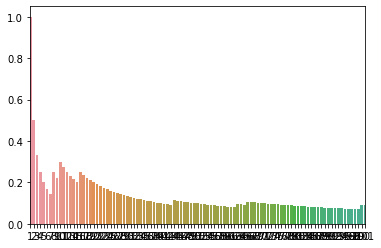

In [ ]:
sns.barplot(x=batch_sizes, y=ratios)
plt.xlim(0, 100)

In [ ]:
acquired_pool_samples_rank = [pool_index_to_rank[pool_index] for pool_index in acquired_pool_samples[:batch_size]]

In [ ]:
sum(np.array(acquired_pool_samples_rank) < len(acquired_pool_samples_rank) * 10) / len(acquired_pool_samples_rank)

0.1782608695652174

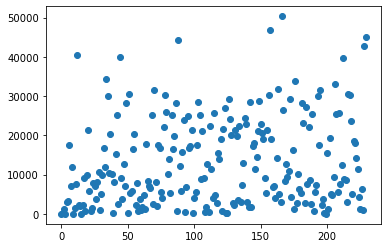

In [ ]:
plt.scatter(range(len(acquired_pool_samples_rank)), acquired_pool_samples_rank)